## Step 1:
Create train/test/validation data


Create raw_data folder and store the data collected here 


create a folder output_data where the .h5 files will be saved.

In [9]:
%matplotlib inline
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
import Cooking
import random
from Cooking import cook
# << Point this to the directory containing the raw data >>
RAW_DATA_DIR = 'raw_data/'
OUTPUT_DIR='output_data/'

cook(RAW_DATA_DIR, OUTPUT_DIR, train_eval_test_split=(0.7, 0.2, 0.1))
# << Point this to the desired output directory for the cooked (.h5) data >>
COOKED_DATA_DIR = 'output_data/'

# The folders to search for data under RAW_DATA_DIR
DATA_FOLDERS = ['images']

# The size of the figures in this notebook
FIGURE_SIZE = (10,10)

Reading data from r...
Reading data from a...
Error: attempting to add image raw_data/images/img_PhysXCar__0_1702451192425733500.png twice.
Reading data from w...
Error: attempting to add image raw_data/images/img_PhysXCar__0_1702451192425733500.png twice.
Reading data from _...
Error: attempting to add image raw_data/images/img_PhysXCar__0_1702451192425733500.png twice.
Reading data from d...
Error: attempting to add image raw_data/images/img_PhysXCar__0_1702451192425733500.png twice.
Reading data from a...
Error: attempting to add image raw_data/images/img_PhysXCar__0_1702451192425733500.png twice.
Reading data from t...
Error: attempting to add image raw_data/images/img_PhysXCar__0_1702451192425733500.png twice.
Reading data from a...
Error: attempting to add image raw_data/images/img_PhysXCar__0_1702451192425733500.png twice.
Reading data from /...
Error: attempting to add image raw_data/images/img_PhysXCar__0_1702451192425733500.png twice.
Processing output_data3/train.h5...
Finis

Let's take a look at the raw data. There are two parts to the dataset - the images and the .tsv file. First, let us read one of the .tsv files.

In [10]:
sample_tsv_path = os.path.join('raw_data','airsim_rec.txt')
sample_tsv = pd.read_csv(sample_tsv_path, sep='\t')
sample_tsv.head()

,VehicleName,TimeStamp,POS_X,POS_Y,POS_Z,Q_W,Q_X,Q_Y,Q_Z,Throttle,Steering,Brake,Gear,Handbrake,RPM,Speed,ImageFile
0,PhysXCar,1702451192295,12.9902,1.02795,4.53922,0.993812,-0.000485,0.001018,0.111072,0.500340,0.185759,0,1,0,2147.07,5.02503,img_PhysXCar__0_1702451192293633700.png
1,PhysXCar,1702451192427,13.4720,1.15997,4.54110,0.992633,-0.000514,0.001308,0.121155,0.451419,0.142396,0,1,0,2123.87,4.99728,img_PhysXCar__0_1702451192425733500.png
2,PhysXCar,1702451192561,13.9534,1.29823,4.54342,0.991672,-0.000707,0.001712,0.128772,0.451419,0.142396,0,1,0,2078.07,4.99409,img_PhysXCar__0_1702451192559161400.png
3,PhysXCar,1702451192703,14.4269,1.44432,4.53271,0.990665,-0.001101,0.001936,0.136301,0.653615,0.014024,0,1,0,2098.61,5.01737,img_PhysXCar__0_1702451192701666200.png
4,PhysXCar,1702451192826,14.9086,1.58461,4.53158,0.990412,-0.000732,0.002595,0.138117,0.653615,0.014024,0,1,0,2225.23,4.81890,img_PhysXCar__0_1702451192824170900.png


This dataset contains our label, the steering angle. It also has the name of the image taken at the time the steering angle was recorded. Let's look at a sample image - 'img_0.png' inside the 'normal_1' folder (more on our folder naming style later).

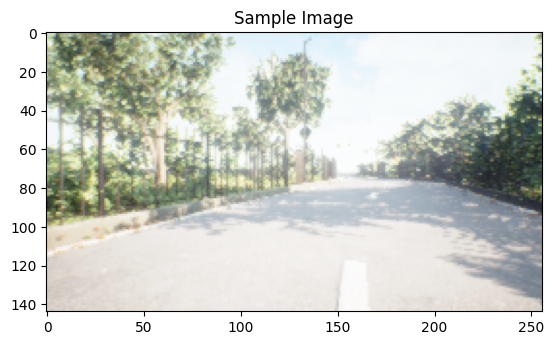

In [13]:
sample_image_path = os.path.join('raw_data/images/img_PhysXCar__0_1702451192293633700.png')
sample_image = Image.open(sample_image_path)
plt.title('Sample Image')
plt.imshow(sample_image)
plt.show()

One immediate observation that we can make about this image is that **only a small portion of the image is of interest**. For example, we should be able to determine how to steer the car by just focusing on the ROI of the image shown in red below

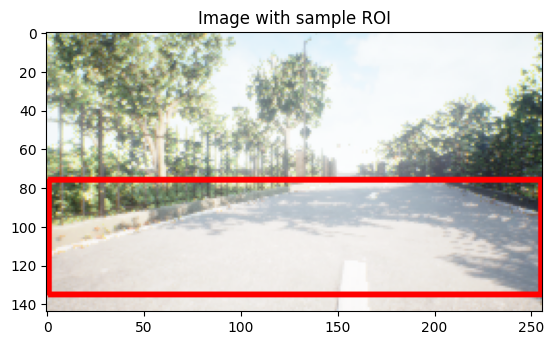

In [14]:
sample_image_roi = sample_image.copy()

fillcolor=(255,0,0)
draw = ImageDraw.Draw(sample_image_roi)
points = [(1,76), (1,135), (255,135), (255,76)]
for i in range(0, len(points), 1):
    draw.line([points[i], points[(i+1)%len(points)]], fill=fillcolor, width=3)
del draw

plt.title('Image with sample ROI')
plt.imshow(sample_image_roi)
plt.show()

**Extracting this ROI will both reduce the training time and the amount of data needed to train the model**. It will also prevent the model from getting confused by focusing on irrelevant features in the environment (e.g. mountains, trees, etc)

Another observation we can make is that **the dataset exhibits a vertical flip tolerance**. That is, we get a valid data point if we flip the image around the Y axis if we also flip the sign of the steering angle. This is important as it effectively doubles the number of data points we have available. 

Additionally, **the trained model should be invariant to changes in lighting conditions**, so we can generate additional data points by globally scaling the brightness of the image.


> **Thought Exercise 0.1:** 
Once you are finished with the tutorial, as an exercise, you should try working with the dataset provided without modifying it using one or more of the 3 changes described above, keeping everything else the same. Do you experience vastly different results? 



> **Thought Exercise 0.2:**
We mentioned in the Readme that end-to-end deep learning eliminates the need for manual feature engineering before feeding the data to the learning algorithm. Would you consider making these pre-processing changes to the dataset as engineered features? Why or why not? 


Now, let's aggregate all the non-image data into a single dataframe to get some more insights.

In [15]:
full_path_raw_folders = [os.path.join('raw_data', f) for f in DATA_FOLDERS]

dataframes = []
for folder in full_path_raw_folders:
    current_dataframe = pd.read_csv(os.path.join('raw_data','airsim_rec.txt'), sep='\t')
    current_dataframe['Folder'] = folder
    dataframes.append(current_dataframe)
    
dataset = pd.concat(dataframes, axis=0)

print('Number of data points: {0}'.format(dataset.shape[0]))

dataset.head()

Number of data points: 1017


,VehicleName,TimeStamp,POS_X,POS_Y,POS_Z,Q_W,Q_X,Q_Y,Q_Z,Throttle,Steering,Brake,Gear,Handbrake,RPM,Speed,ImageFile,Folder
0,PhysXCar,1702451192295,12.9902,1.02795,4.53922,0.993812,-0.000485,0.001018,0.111072,0.500340,0.185759,0,1,0,2147.07,5.02503,img_PhysXCar__0_1702451192293633700.png,raw_data\images
1,PhysXCar,1702451192427,13.4720,1.15997,4.54110,0.992633,-0.000514,0.001308,0.121155,0.451419,0.142396,0,1,0,2123.87,4.99728,img_PhysXCar__0_1702451192425733500.png,raw_data\images
2,PhysXCar,1702451192561,13.9534,1.29823,4.54342,0.991672,-0.000707,0.001712,0.128772,0.451419,0.142396,0,1,0,2078.07,4.99409,img_PhysXCar__0_1702451192559161400.png,raw_data\images
3,PhysXCar,1702451192703,14.4269,1.44432,4.53271,0.990665,-0.001101,0.001936,0.136301,0.653615,0.014024,0,1,0,2098.61,5.01737,img_PhysXCar__0_1702451192701666200.png,raw_data\images
4,PhysXCar,1702451192826,14.9086,1.58461,4.53158,0.990412,-0.000732,0.002595,0.138117,0.653615,0.014024,0,1,0,2225.23,4.81890,img_PhysXCar__0_1702451192824170900.png,raw_data\images


Let us now address the naming of the dataset folders. You will notice that we have two types of folders in our dataset - 'normal', and 'swerve'. These names refer to two different driving strategies. Let's begin by attempting to get an understanding of the differences between these two styles of driving. First, we'll plot a portion of datapoints from each of the driving styles against each other.

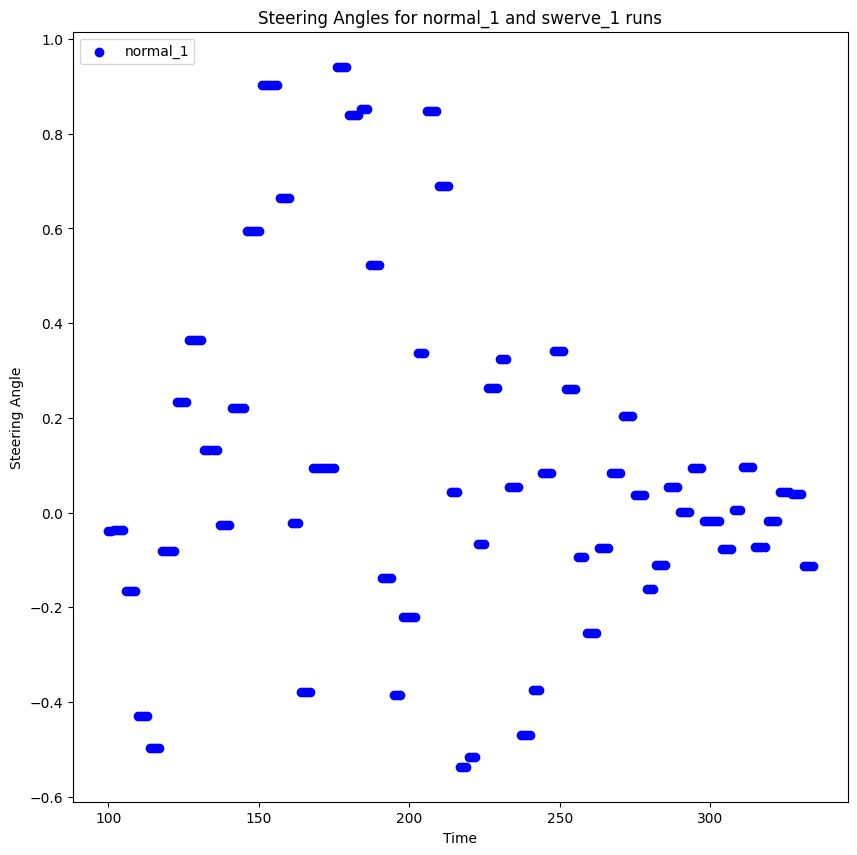

In [16]:
min_index = 100
max_index = 335
steering_angles_normal_1 = dataset[dataset['Folder'].apply(lambda v: 'images' in v)]['Steering'][min_index:max_index]

plot_index = [i for i in range(min_index, max_index, 1)]

fig = plt.figure(figsize=FIGURE_SIZE)
ax1 = fig.add_subplot(111)

ax1.scatter(plot_index, steering_angles_normal_1, c='b', marker='o', label='normal_1')
plt.legend(loc='upper left')
plt.title('Steering Angles for normal_1 and swerve_1 runs')
plt.xlabel('Time')
plt.ylabel('Steering Angle')
plt.show()